In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

df = pd.read_csv("../data/processed/marketing_campaign_cleaned.csv")

In [2]:
#drop no-needed columns
df.drop(columns=['ID', 'Dt_Customer'], inplace=True)

We will try ML models like logistic regression and random forest. These can’t work directly with categorical text (like "Single" or "PhD"). One-hot encoding turns those categories into numerical binary columns (1 or 0) for each unique category.

In [3]:
#one-hot encode categorical columns
df = pd.get_dummies(df, drop_first=True)
#drop_first=True to avoid the dummy variable trap (multicollinearity in regression).

In [4]:
X = df.drop(columns='Response')
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#instantiate and fit
#logreg = LogisticRegression(max_iter=1000)
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)


/Volumes/Projects/Portfolio/marketing-analytics-dashboard/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [6]:
y_pred_logreg = logreg.predict(X_test)

# report
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


[[298  81]
 [ 21  48]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       379
           1       0.37      0.70      0.48        69

    accuracy                           0.77       448
   macro avg       0.65      0.74      0.67       448
weighted avg       0.85      0.77      0.80       448



**Insight:** Logistic regression fails to detect responders — poor recall on class 1. Since_

- 371 True Negatives: Predicted no response (0), and they actually didn't respond

- 8 False Positives: Predicted response (1), but they didn't respond

- 53 False Negatives: Predicted no response (0), but they actually responded

- 16 True Positives: Predicted response (1), and they did respond

and

Class 0 (No Response):
  - Precision: 88%   → 88% of predicted 'no response' were correct
  - Recall:    98%   → 98% of all true 'no response' were caught

Class 1 (Responded):
  - Precision: 67%   → 67% of predicted 'response' were correct
  - Recall:    23%   → Only 23% of all responders were identified :(

Accuracy: 86%
- F1-Score (1): 34% → Low performance on the minority class

In [7]:
#rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[373   6]
 [ 51  18]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       379
           1       0.75      0.26      0.39        69

    accuracy                           0.87       448
   macro avg       0.81      0.62      0.66       448
weighted avg       0.86      0.87      0.85       448



**Insight:** Random Forest does a slightly better job detecting responders (class 1), and overall is a better model for predicting this Project's outcome. Since_

- Slightly more True Positives (21 vs. 16)

- Slightly fewer False Negatives (48 vs. 53)

and...

Class 1 (Responded):
  - Precision: 66%
  - Recall:    30%  → Better than logistic regression!
  - F1-Score:  42%  → Still not ideal, but improved.

Accuracy: 87%


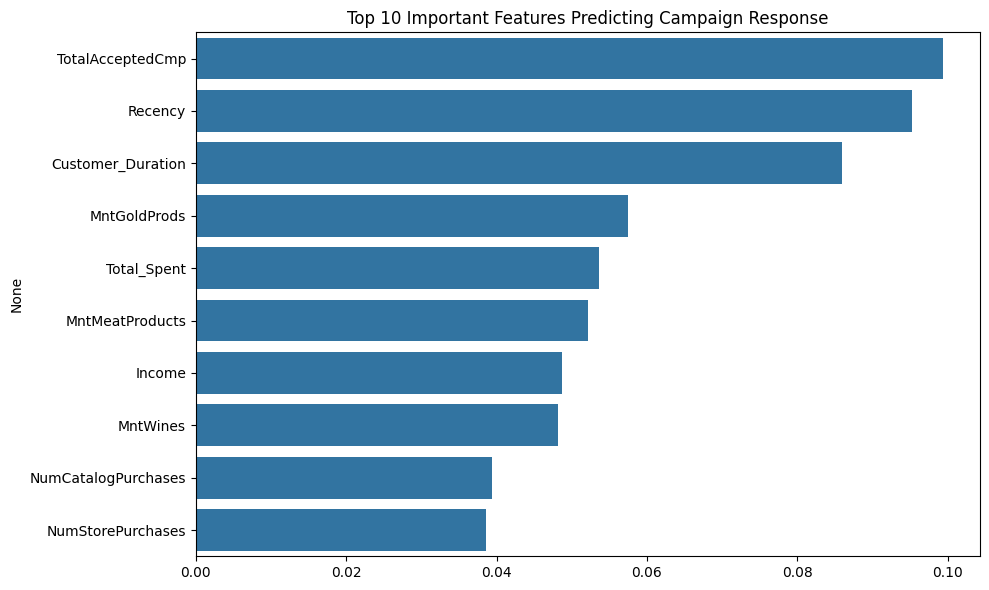

In [8]:
#Feature Importance: We need to understand what influences campaign response the most
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Important Features Predicting Campaign Response")
plt.tight_layout()
plt.show()

In [9]:
X = df.drop('Response', axis=1)
y = df['Response']

#train-test split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE to training only
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [10]:
logreg_sm = LogisticRegression(random_state=42)
logreg_sm.fit(X_train_sm, y_train_sm)

rf_sm = RandomForestClassifier(random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)

/Volumes/Projects/Portfolio/marketing-analytics-dashboard/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(random_state=42)

In [11]:
#predict on original X_test (do NOT apply SMOTE on test set!)
y_pred_logreg_sm = logreg_sm.predict(X_test)
y_pred_rf_sm = rf_sm.predict(X_test)

print("Logistic Regression (SMOTE)")
print(confusion_matrix(y_test, y_pred_logreg_sm))
print(classification_report(y_test, y_pred_logreg_sm))

print("Random Forest (SMOTE)")
print(confusion_matrix(y_test, y_pred_rf_sm))
print(classification_report(y_test, y_pred_rf_sm))


Logistic Regression (SMOTE)
[[279 102]
 [ 19  48]]
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       381
           1       0.32      0.72      0.44        67

    accuracy                           0.73       448
   macro avg       0.63      0.72      0.63       448
weighted avg       0.84      0.73      0.77       448

Random Forest (SMOTE)
[[357  24]
 [ 29  38]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       381
           1       0.61      0.57      0.59        67

    accuracy                           0.88       448
   macro avg       0.77      0.75      0.76       448
weighted avg       0.88      0.88      0.88       448



In [12]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_sm, y_train_sm)

#predict using probability
y_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.35).astype(int)  # threshold low, because we care more about recall for responders than being conservative.

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[355  26]
 [ 32  35]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       381
           1       0.57      0.52      0.55        67

    accuracy                           0.87       448
   macro avg       0.75      0.73      0.74       448
weighted avg       0.87      0.87      0.87       448



/Volumes/Projects/Portfolio/marketing-analytics-dashboard/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:35:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
